In [ ]:
# # Details For the Attention Basics:
# -> importation
# # from tqdm.notebook import trange, tqdm
# # Define the Root Directory
# # Transformations : convert into tensor & Normalisation.
# # Load The Dataset
# # randomly select indices from the datatset and concatenate the image into a tensor
#   shape of dataset_tensor :(N,F)
#     len(rand_perm) = N (number of samples),
#     each sample has F features after flattening,

# # Indexing a Dataset:
#   Using Matrixs Multiplication: the query Tensor is Multiplied With the key Shuffled Matrix to get the one hot Selcted data.(Shuffled matrix will be discovered by the querry.)
#   Thats How we get our index map.

# # Why And How Attention: When you stop using "hard" one-hot coded vectors, you move from a simple lookup mechanism to the core concept behind the attention mechanism used in state-of-the-art models like Transformers. 🧠
#   Instead of retrieving one specific item, this new process creates a blended output—a weighted average of all items in the dataset, where the weights are determined by how well each item's "key" matches the "query."
#   ->You are no longer using one-hot vectors that just point to an index. Instead, the query and keys are dense vectors (also called embeddings).
#    Calculating Similarity Scores (Logits)
#    ->This matrix multiplication q @ k.t() now measures the similarity between your query vector and every key vector in the dataset. The dot product is a measure of alignment; a higher value means the query and a specific key
#      are more similar in the high-dimensional space. The result is a vector of raw similarity scores, often called logits.
#    Now Create a Probability Distribution.(Softmax)
#    retrive a Weighted Average.

# # With Multiple Queries & multi Head Attention.


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 511kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.0MB/s]


Dataset tensor shape: torch.Size([100, 784])


Epochs: 100%|██████████| 5/5 [01:23<00:00, 16.75s/it]


Training finished.
Minimum loss: 0.11896269768476486


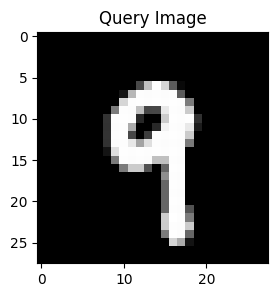

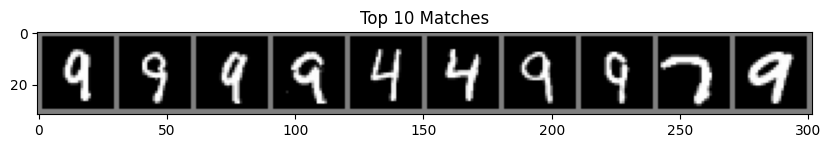

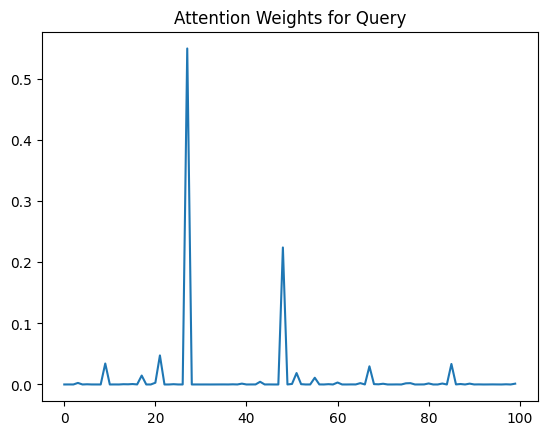

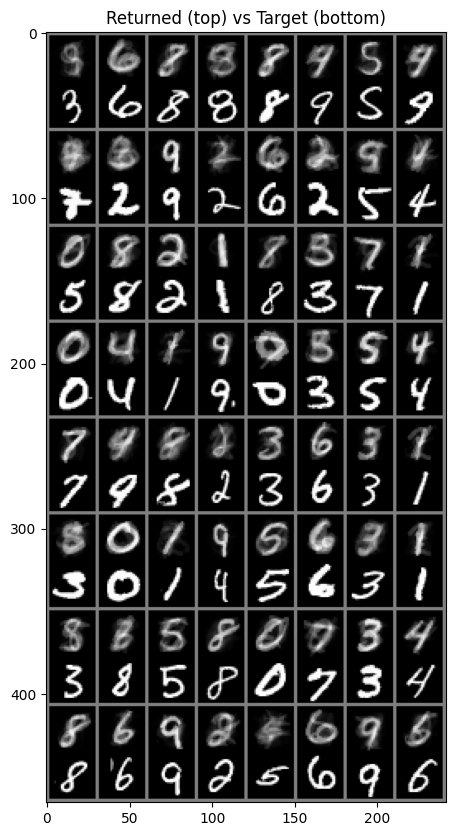

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data.dataloader as dataloader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange, tqdm

# ----------------------------
# Dataset Preparation (MNIST)
# ----------------------------
data_set_root = "./datasets"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.MNIST(
    data_set_root, train=True, download=True, transform=transform
)

num_of_examples = 100  # fixed dataset subset

# pick random examples
rand_perm = torch.randperm(dataset.data.shape[0])[:num_of_examples]

# stack into single tensor
dataset_tensor = torch.cat([
    dataset.__getitem__(i)[0].reshape(1, -1) for i in rand_perm
])

print("Dataset tensor shape:", dataset_tensor.shape)  # (100, 784)


# ----------------------------
# Multi-Head Attention Model
# ----------------------------
class AttentionTest(nn.Module):
    def __init__(self, num_of_examples=100, embed_dim=784, num_heads=4):
        super(AttentionTest, self).__init__()

        self.img_mlp = nn.Sequential(
            nn.Linear(784, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.ELU(),
            nn.Linear(embed_dim, embed_dim)
        )

        self.mha = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )

    def forward(self, img, values):
        img_ = self.img_mlp(img)        # (B, 1, embed_dim)
        values_ = self.img_mlp(values)  # (B, num_examples, embed_dim)

        attn_output, attn_output_weights = self.mha(img_, values_, values_)

        # soft indexing into original values
        output = torch.bmm(attn_output_weights, values)

        return output, attn_output_weights


# ----------------------------
# Training Setup
# ----------------------------
embed_dim = 256
num_heads = 4
batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = dataloader.DataLoader(
    dataset,
    shuffle=True,
    batch_size=batch_size,
    num_workers=2,
    drop_last=True
)

mha_model = AttentionTest(
    num_of_examples=num_of_examples,
    embed_dim=embed_dim,
    num_heads=num_heads
).to(device)

optimizer = optim.Adam(mha_model.parameters(), lr=1e-4)

values_tensor = dataset_tensor.unsqueeze(0).expand(batch_size, num_of_examples, -1).to(device)

loss_logger = []

# ----------------------------
# Training Loop
# ----------------------------
mha_model.train()
epochs = 5

for _ in trange(epochs, desc="Epochs"):
    for data, _ in tqdm(train_loader, leave=False):
        q_img = data.reshape(data.shape[0], 1, -1).to(device)

        attn_output, attn_output_weights = mha_model(q_img, values_tensor)

        loss = (attn_output - q_img).pow(2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_logger.append(loss.item())

print("Training finished.")
print("Minimum loss:", np.min(loss_logger))


# ----------------------------
# Evaluation
# ----------------------------
mha_model.eval()
with torch.no_grad():
    q_img = data.reshape(data.shape[0], 1, -1).to(device)
    attn_output, attn_output_weights = mha_model(q_img, values_tensor)

# pick an index from batch
index = 10
top10 = attn_output_weights[index, 0].argsort(descending=True)[:10]
top10_data = values_tensor[index, top10].cpu()

# plot original query image
plt.figure(figsize=(3, 3))
out = torchvision.utils.make_grid(q_img[index].cpu().reshape(-1, 1, 28, 28), 1, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.title("Query Image")
plt.show()

# plot top 10 matches
plt.figure(figsize=(10, 10))
out = torchvision.utils.make_grid(top10_data.reshape(-1, 1, 28, 28), 10, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.title("Top 10 Matches")
plt.show()

# plot attention weights
plt.plot(attn_output_weights[index, 0].cpu().numpy().flatten())
plt.title("Attention Weights for Query")
plt.show()

# visualize query vs returned
target_img = q_img.reshape(batch_size, 1, 28, 28)
indexed_img = attn_output.reshape(batch_size, 1, 28, 28)

img_pair = torch.cat((indexed_img, target_img), 2).cpu()
plt.figure(figsize=(10, 10))
out = torchvision.utils.make_grid(img_pair, 8, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.title("Returned (top) vs Target (bottom)")
plt.show()
